# TOPIC MODELLING 
>indentifying topics within a corpus(set of documents)

imports

In [ ]:
import base64
import numpy as np
import pandas as pd

# Plotly imports -graphing libraries
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# Other imports
from collections import Counter
from matplotlib.pyplot import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
%matplotlib inline

reading the training dataset

In [ ]:
train = pd.read_csv("/content/train.csv")

In [ ]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


# 1.Exploratory Data Analysis

understanding the frequency distribution of the authors

In [ ]:

z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}
data = [go.Bar(
    #takes the list of authors,map the author names to the values of the dictionary and draw just the unique authors
            x = train.author.map(z).unique(),
            #number of times the authors names occur
            y = train.author.value_counts().values,
            #colorsale=plotly palettes
            #takes the value of occurence 0f an author and corresponds it to the palette scale
            marker= dict(colorscale='Blackbody',
                         color = train.author.value_counts().values
                        ),
            text='Text entries attributed to Author'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

fig.show(renderer='colab')

Understanding the frequency distribution of words

In [ ]:
#first we split the strings apart then we need the values of all words and the words
#expand=true expands the list items of columns of data on which unstacking(making them a single column) can be performed
#so all words is like words and their frequencies sorted in descending order
all_words = train['text'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
    #index is an object which contains in it the list of words
    #index.values gives us access to the words in the list
            x = all_words.index.values[1:51],
            y = all_words.values[1:51],
            marker= dict(colorscale='Jet',
                         color = all_words.values[1:51]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

fig.show(renderer='colab')

collecting the text corresponding to each author

In [ ]:
#finding out the rows that belong to a particular author
#train[train.author==eap] gives the entire row belonging to the author.we want the text column
#text gives just the text and id
#.values gives an array of all the texts
eap=train[train.author=='EAP']['text'].values
hpl=train[train.author=='HPL']['text'].values
mws=train[train.author=='MWS']['text'].values


Visualizing the word types

In [ ]:
#wordcloud is used for visualizing the word types(unique words) in a corpus of text.
#bigger the word in the wordcloud,the more frequent it occurred
#stopwords are words that donot bring much meaning in general or when lacks the context such as he,the,of,it
from wordcloud import WordCloud, STOPWORDS


In [ ]:
#the text corresponding to each author after eliminating(ignoring) stopwords is displayed in the form of a masked wordcloud
planemask=plt.imread('/content/eap.png',0)
plt.figure(figsize=(20,18))
plt.subplot(211)
wc = WordCloud(background_color="white", 
               max_words=10000, 
               mask=planemask, 
               stopwords=STOPWORDS, 
               max_font_size= 40)
wc.generate(" ".join(eap))
plt.title("Edgar Allen Poe")
plt.imshow(wc.recolor( colormap= 'PuBu' , random_state=17), alpha=0.9)
plt.axis('off')

In [ ]:
plt.figure(figsize=(10,10))
wc = WordCloud(background_color="black", max_words=10000, 
              stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(hpl))
plt.title("HP Lovecraft ", fontsize=20)
plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=1), alpha=1)
plt.axis('off')

In [ ]:
plt.figure(figsize=(20,18))
wc = WordCloud(background_color="white", 
               max_words=10000,  
               stopwords=STOPWORDS, 
               max_font_size= 40)
wc.generate(" ".join(mws))
plt.title("Mary Shelley ", fontsize= 18)
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), alpha=0.9)
plt.axis('off')

# 2. Preprocessing the data:

*   Tokenization (breaking apart the corpus to individual words) 
*   Stopword Removal 
*   Stemming (reduces words to root by trimming suffixes,prefixes) , lemmetization(converts word to a meaningful base form)
*   Vectorization ( words to vector form)





In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# 3. Topic Modelling

> Latent Dirichlet Allocation -revolves around corpus,collection of documents,words in the documents. LDA tries to uncover topics in the corpus.A document is characterized by a set of topics and each topic is characterized by a set of words.

> parts in LDA : calculating words that belong to a document and words that belong to a topic(prob of the word belonging to a topic) . start with a pre-set no of topics(an assumption of the number of topics - represented by k). Loop through 'm' document and initially randomly assign each word in the document to one of the assumed k topics. with each document, loop through the words (each word represented by W) and calculate p(t|d) - proportion of words in document d that are assigned to topic t(words distribution in a topic) . Update the probability for the word w belonging to topic , loop through each word and reassign the topic for the selected word over the set number of iterations

> simply put : take a few documents .assign the words randomly to the assumed number of topics.take a word in the 1st doc,assume its topic has been wrongly assigned but every other word is correctly assigned to its topic.find out the topic distribution over the document which helps us answer which topic is at what percentage in that document.the probability of the current word being in a topic depends on the topic distribution in the doc and what topics the same word in other documents is assigned to.Assuming that the probabilities are independant of each other, we multiply the probability for a topic in the doc with the probability of the word being in a topic after adding the individual properties to dirichlet priors.then the word is assigned to the topic with highest probability value .the looping process goes through all the words in the coorpus and for multiple iterations. Generally the number of set topics effects the end result which should be understandable by humans. We can improve the perplexity score and coherence score.we can tell the best number to set for the topics by building multiple models with different no of topic and finding out which model gives the best coherence score. its called latent dirichlet because the parameters are hidden and the distributions are array of distributions which sum up to 1.

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [ ]:
#countvectorizer combines all the preprocessing steps and its functionality is extended to lemmatize the words by overwriting the build_analyzer method
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [ ]:
# Storing the entire training text in a list
text = list(train.text.values)
# Calling our overwritten Count vectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

In [ ]:
feature_names = tf_vectorizer.get_feature_names()
count_vec = np.asarray(tf.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))
# Now I want to extract out on the top 15 and bottom 15 words
Y = np.concatenate([y[0:15], y[-16:-1]])
X = np.concatenate([x[0:15], x[-16:-1]])

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[0:50],
            y = y[0:50],
            marker= dict(colorscale='Jet',
                         color = y[0:50]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)


fig.show(renderer='colab')

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[-100:],
            y = y[-100:],
            marker= dict(colorscale='Portland',
                         color = y[-100:]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Bottom 100 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)


fig.show(renderer='colab')

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [ ]:
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=11, random_state=0)

In [ ]:
n_top_words = 40
print("\nTopics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:mean night fact young return great human looking wonder countenance difficulty greater wife finally set possessed regard struck perceived act society law health key fearful mr exceedingly evidence carried home write lady various recall accident force poet neck conduct investigation

Topic #1:death love raymond hope heart word child went time good man ground evil long misery replied filled passion bed till happiness memory heavy region year escape spirit grief visit doe story beauty die plague making influence thou letter appeared power

Topic #2:left let hand said took say little length body air secret gave right having great arm thousand character minute foot true self gentleman pleasure box clock discovered point sought pain nearly case best mere course manner balloon fear head going

Topic #3:called sense table suddenly sympathy machine sens unusual labour thrown mist solution suppose specie movement whispered urged frequent wine hour appears ring tu

In [ ]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]
fourth_topic = lda.components_[3]

In [ ]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

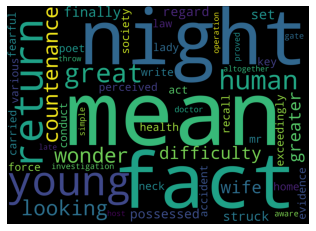

In [ ]:
firstcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

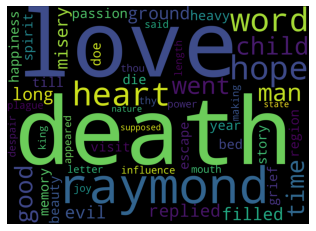

In [ ]:
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(second_topic_words))
plt.imshow(cloud)
plt.axis('off')
plt.show()

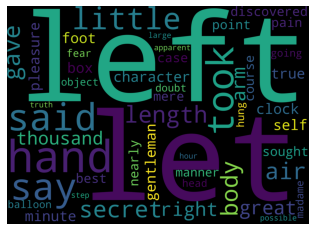

In [ ]:
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(third_topic_words))
plt.imshow(cloud)
plt.axis('off')
plt.show()

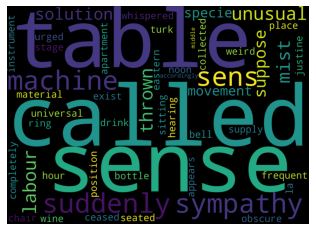

In [ ]:
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(fourth_topic_words))
plt.imshow(cloud)
plt.axis('off')
plt.show()